In this notebook we will show how to use the mosaicing technique to localize a GRB occuring inside the BAT FOV while Swift is slewing

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO 
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


We use GRB 210706A, detected by Fermi, as an example

In [2]:
triggertime = '2021-07-06T08:17:49.86Z'

In [3]:
guano = GUANO(triggertime=triggertime)
print(guano)

+--------------+---------------------+------------+---------------------+----------------+
| Trigger Type |        Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+---------------------+------------+---------------------+----------------+
|      GBM GRB | 2021-07-06 08:17:49 |         50 |                 200 |    00048739198 |
+--------------+---------------------+------------+---------------------+----------------+


In [4]:
from swifttools.swift_too import GUANO, Clock, Data

obsid = guano[0].obsid

tmp_download_dir="./tmp/bat"

data = Data(obsid=obsid, bat=True, outdir=tmp_download_dir, clobber=True)
ba.datadir(tmp_download_dir)
event=ba.BatEvent(obsid, is_guano=True)




After checking the existence of GUANO data and downloading them, we make a mosaic in the first 10 sec from the trigger time

In [15]:
min_time = 0.0
max_time = 10.0

time_bins=np.arange(min_time, max_time, 0.2)*u.s

energybins=[ 15., 350]*u.keV

t0 = float(guano[0].triggertime.met)


slew_skyviews=ba.parallel.create_event_skyview(event, timebins=time_bins, energybins=energybins, is_relative=True, T0=t0, nprocs=8)


In [16]:
mosaic_skyview = ba.parallel.mosaic_skyview(slew_skyviews, nprocs=8)

/tmp/ipykernel_3157179/333079197.py:1: UserWarning: This parallel image addition can be memory intensive. Allocate ~10-15 GB of memory per process.
/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the de

/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.



/storage/work/sjs8171/anaconda3/envs/bat_dev/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.


In [17]:
mosaic_detected_sources = mosaic_skyview.detect_sources(input_dict=dict(pcodethresh=0.01, snrthresh=5, aperture="CALDB:DETECTION"))

In [18]:
mosaic_detected_sources

SNR_skycoord,SNR,closest_source,closest_source_skycoord,separation,psffwhm_separation,ebin
"deg,deg",,,"deg,deg",deg,,
SkyCoord,float64,str30,SkyCoord,float64,float64,float64[2]
"311.95834599776583,13.289819760533899",39.57959864877666,SWIFT J2106.2+1402,"316.5,14.03",4.474733288366216,11.960370161083622,15.0 .. 350.0
"312.0736732612059,13.313050329770935",38.54973963551528,SWIFT J2106.2+1402,"316.5,14.03",4.3601699829716605,11.654157600223613,15.0 .. 350.0
"311.941210053855,13.403215976127125",30.332927804472735,SWIFT J2106.2+1402,"316.5,14.03",4.47281738188285,11.955249196490122,15.0 .. 350.0
"312.09084670285944,13.199666557383827",29.15893539789892,SWIFT J2106.2+1402,"316.5,14.03",4.3648592699226505,11.666691443943684,15.0 .. 350.0
"311.97557521615465,13.176441180308245",29.076656948976794,SWIFT J2106.2+1402,"316.5,14.03",4.479467928841988,11.973025228776061,15.0 .. 350.0
"312.0565936424884,13.426451729994795",28.93380061392341,SWIFT J2106.2+1402,"316.5,14.03",4.358376090206589,11.649362762159111,15.0 .. 350.0
"311.8430603863495,13.266430898876576",23.851285467615885,SWIFT J2106.2+1402,"316.5,14.03",4.589299007849526,12.266589174483537,15.0 .. 350.0
"312.1890420570922,13.336121982434012",21.593782980148884,SWIFT J2106.2+1402,"316.5,14.03",4.245609098192175,11.347951509347487,15.0 .. 350.0


we extract the coordinates of the candidate with highest SNR

In [20]:
ra = mosaic_detected_sources[0]['SNR_skycoord'].ra.deg
dec = mosaic_detected_sources[0]['SNR_skycoord'].dec.deg
object_location=SkyCoord(ra = ra * u.deg, dec= dec * u.deg)

Here we use the coordinates found before to see the partial coding at the GRB position as a function of time

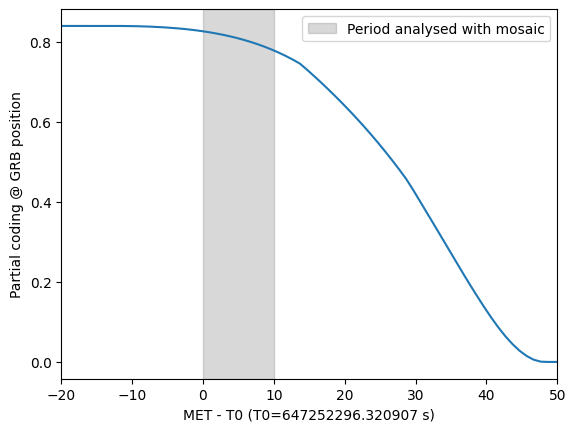

In [22]:
import swiftbat

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name='test'
)

time = event.attitude.time.value - t0*np.ones(len(event.attitude.time))

exposures = np.array(
    [object_batsource.exposure(ra=ra,
                               dec=dec, 
                               roll=roll)[0]
        for ra,dec,roll in zip(event.attitude.ra,event.attitude.dec,event.attitude.roll)
    ])

plt.plot(time,exposures/5200)
plt.xlim(-20,50)
plt.axvspan(min_time, max_time, color='gray', alpha=0.3, label="Period analysed with mosaic")
plt.legend()
plt.xlabel('MET - T0 (T0=%s s)' %t0)
plt.ylabel('Partial coding @ GRB position')

plt.savefig('pc.pdf', dpi=500)

In [11]:
event.apply_mask_weighting(ra=object_location.ra, dec=object_location.dec)

After applying the mask weighting, we build a lightcurve, specifying a equally spaced binning of 1024 s

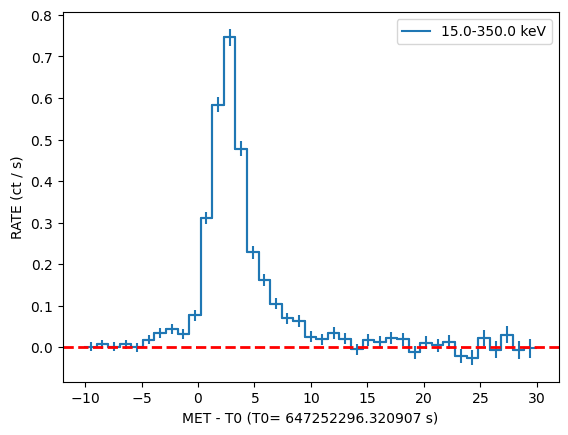

In [29]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(
                timebinalg="uniform",
                timedelta=np.timedelta64(1024, 'ms'),
                tmin=-10*u.s,
                tmax=30*u.s,
                is_relative=True,
                T0=guano[0].triggertime.met)

lc.plot(T0=guano[0].triggertime.met, plot_relative=True)
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)

plt.savefig('lc.pdf', dpi=500)

Same as above, but using Bayesian blocks

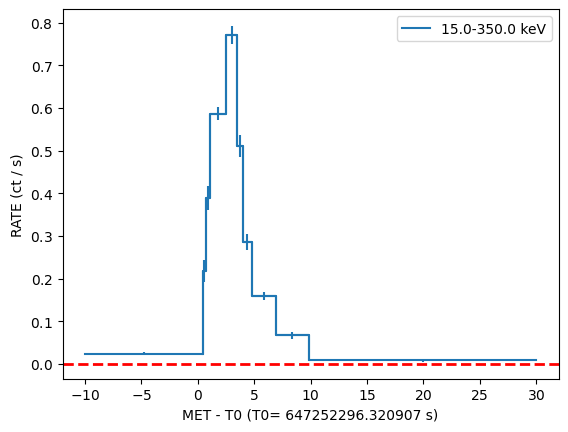

In [13]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(timebinalg="bayesian", save_durations=True)
lc.plot(T0=guano[0].triggertime.met, plot_relative=True)
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)



We then extract the spectrum in the t90 interval found with the Bayesian blocks and we fit with a power law

In [14]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'], tstop=lc.tdurs['T90']['TSTOP'])


1 spectrum  in use
 
Spectral Data File: t_647252297.200907-647252303.472907_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.420e-01 +/- 2.455e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 6.272 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252297.200907-647252303.472907_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000     +/-  0.0          
   4    2   powerlaw   PhoIndex            -1.00000     +/-  0.0          
   5    2   powerlaw   norm                1.00000E-03  frozen
________________________________________________________________________


Fit statistic  : Chi-Squared      

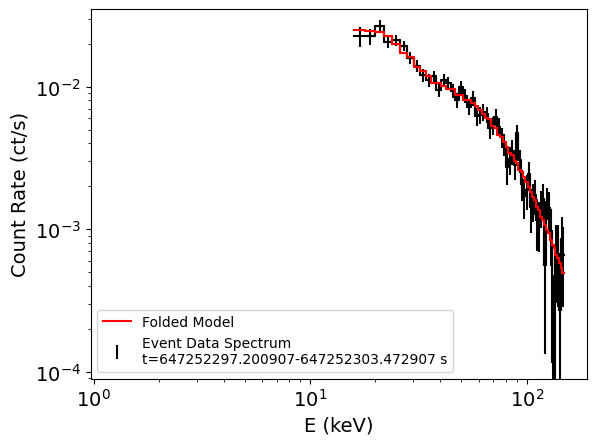

In [15]:
ba.fit_spectrum(spectrum_t90, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, use_cstat=False, fit_iterations=10000)

In [16]:
spectrum_t90.spectral_model

{'parameters': {'Emin': {'val': 15.0,
   'lolim': 0.0,
   'hilim': 0.0,
   'errflag': 'FFFFFTFFF'},
  'Emax': {'val': 150.0, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'},
  'lg10Flux': {'val': -6.613894267769764,
   'lolim': -6.62911335996921,
   'hilim': -6.599151917069104,
   'errflag': 'FFFFFFFFF'},
  'PhoIndex': {'val': 1.575635367617372,
   'lolim': 1.5134209014499833,
   'hilim': 1.6381603835054177,
   'errflag': 'FFFFFFFFF'},
  'norm': {'val': 0.001, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'}},
 'data': {'model_spectrum': <Quantity [0.02486539, 0.02473876, 0.0240552 , 0.02247769, 0.02001328,
             0.01728942, 0.0161876 , 0.01380409, 0.01289973, 0.0118446 ,
             0.01068567, 0.0106548 , 0.0100784 , 0.00968037, 0.00968973,
             0.00878683, 0.00880002, 0.00800285, 0.00803428, 0.00766227,
             0.00729301, 0.00684428, 0.00644816, 0.00605026, 0.00591876,
             0.00529505, 0.00513954, 0.00455279, 0.00440411, 0.00407152,
             

In [17]:
bayesian_spectra=event.create_pha(tstart=lc.tbins["TIME_START"], tstop=lc.tbins["TIME_STOP"])

In [18]:
output_bayesian_spectra=ba.parallel.batspectrum_analysis(bayesian_spectra, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, nprocs=1, use_cstat=False, fit_iterations=10000, recalc=True)


1 spectrum  in use
 
Spectral Data File: t_647252286.3209069-647252296.752907_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.785e-02 +/- 4.884e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 10.43 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252286.3209069-647252296.752907_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                14146.17     using 80 bins.

Test statistic : Chi-Squared                14146.17     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000     +/-  0.0     

The condition here is 3.437955751248967e-07 [3.2615363773590916e-07, 3.6151873266911244e-07] 3 1.7682547466601636e-08 2.907479327250918e-07

1 spectrum  in use
 
Spectral Data File: t_647252298.864907-647252299.8249071_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.511e-01 +/- 4.855e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 0.96 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252298.864907-647252299.8249071_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                  186.93     using 80 bins.

Test statistic : Chi-Squared                  186.93     using 80 bins.
 Null hypothesis probability of 6.26e-11 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      


1 spectrum  in use
 
Spectral Data File: t_647252301.104907-647252303.216907_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.749e-01 +/- 1.582e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 2.112 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252301.104907-647252303.216907_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                  331.86     using 80 bins.

Test statistic : Chi-Squared                  331.86     using 80 bins.
 Null hypothesis probability of 4.87e-33 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -9.00000     +/-  0.0       


1 spectrum  in use
 
Spectral Data File: t_647252306.2249072-647252326.3209069_80chan_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.585e-01 +/- 9.364e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 20.1 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_647252306.2249072-647252326.3209069_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                42935.26     using 80 bins.

Test statistic : Chi-Squared                42935.26     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            2.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
____________________________________________

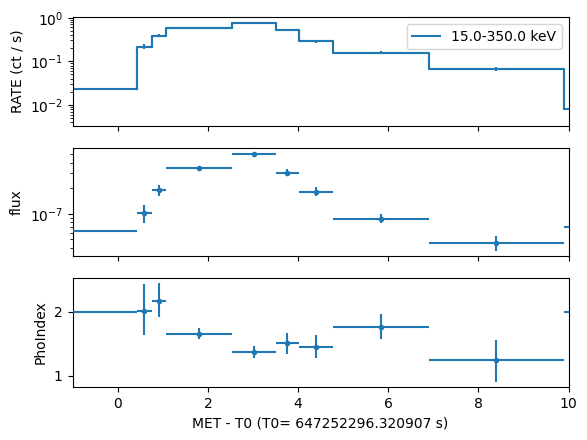

In [19]:
fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=t0)#, energy_range=None)
for i in ax:
    #i.set_xlim([-1,120])
    i.set_xlim([-1,10])
    
ax[0].set_yscale("log")

plt.savefig('spe_evo.pdf', dpi=500)